In [19]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from linearmodels.panel import PanelOLS

pd.options.display.max_columns = 500
pd.options.display.max_rows = 5000

os.getcwd()
os.chdir('c:\\Users\\zach_\\Desktop\\Research\\Github\\RFE_project')

new data

In [20]:
datapath_prob = Path("C:\\Users\\zach_\\Nobackupfile\\Data\\BDS\\Regdata\\RegData-US_4-1\\2digit_probability.csv")
datapath_doc = Path("C:\\Users\\zach_\\Nobackupfile\\Data\\BDS\\Regdata\\RegData-US_4-1\\document_restrictions.csv")

df_ind = pd.read_csv(datapath_prob)
df_doc = pd.read_csv(datapath_doc)

In [21]:
# clean variables
df_doc = df_doc.drop_duplicates("document_id")
df_doc["year"] = pd.to_numeric(df_doc.date.str.slice(0,4))

# create current measure
doc_var = [
    "year",
    "document_id",
    "agency",
    "document_reference",
    "restrictions_2_0",
    ]

df_merge_part = df_ind.merge(
    df_doc[doc_var], 
    how='inner', 
    on=["document_id"], 
    validate="many_to_one",
    )

df_merge_part["reg_s_d"] = df_merge_part["probability"] * df_merge_part["restrictions_2_0"]
df_merge = df_merge_part.groupby(["year", "industry", "agency"])[["reg_s_d", "restrictions_2_0"]].sum()
df_merge = df_merge.reset_index()


# initial shares
df_merge["reg_s"] = df_merge.groupby(["industry", "year"])["reg_s_d"].transform(lambda x: x.sum())
df_merge["share"] = np.where(df_merge["reg_s_d"]>0, df_merge["reg_s_d"] / df_merge["reg_s"], 0)

# replace non record with zero
for var in ["reg_s_d", "reg_s", "share"]:
    df_merge[var] = np.where(df_merge[var].isna(), 0, df_merge[var])
    
# create initial shares
baseline_year = 1986
df_init = df_merge.loc[
    df_merge.year == baseline_year,
    ["industry", "agency", "share"]
    ]
df_init = df_init.rename(columns = {"share": "share_init"})

# merge with main dataset
init_var = ["industry", "agency", "share_init"]
df_merge = df_merge.merge(df_init[init_var], how='left', on=["industry", "agency"], validate="many_to_one")


In [27]:

df_share = pd.pivot_table(df_init, values="share_init", index=["industry"], columns=["agency"])

In [28]:
# load life path data
datapath_sec = Path("data/cleaned/data_final_sec.h5")
df = pd.read_hdf(datapath_sec, key="data")


In [30]:
df_1986 = df[df.year == 1986]

In [32]:
df_test_iv = df_1986.merge(df_share, left_on="sector_2", right_on="industry")

,document_id,industry,probability,year,agency,document_reference,restrictions_2_0,reg_s_d
60540,12300003028,11,0.0007,1970,AbilityOne,"Title 41, Part 51",45,0.0315
142239,12300007112,11,0.0005,1971,AbilityOne,"Title 41, Part 51",43,0.0215
228120,12300011407,11,0.0004,1972,AbilityOne,"Title 41, Part 51",45,0.0180
317340,12300015868,11,0.0002,1973,AbilityOne,"Title 41, Part 51",46,0.0092
410520,12300020527,11,0.0002,1974,AbilityOne,"Title 41, Part 51",112,0.0224


c:\Users\zach_\.virtualenvs\RFE_project-5yjSZlxr\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


KeyError: 'restrictions_2_0'

,year,industry,agency,reg_s_d,reg_s,share,share_init
0,1970,11,AbilityOne,0.0315,28824.3558,1.092826e-06,4.134966e-06
1,1970,11,Advisory Commission On Intergovernmental Relat...,0.0028,28824.3558,9.714007e-08,3.838149e-08
2,1970,11,American Battle Monuments Commission,0.0699,28824.3558,2.425033e-06,1.549077e-05
3,1970,11,Appalachian Regional Commission,0.0012,28824.3558,4.163146e-08,6.141038e-08
4,1970,11,Armed Forces Retirement Home,0.0024,28824.3558,8.326292e-08,0.000000e+00


In [ ]:


#df_merge["sum_log_reg_s_d"] = df_merge.groupby(["document_reference", "year"])["log_reg_s_d"].transform(lambda x: x.sum())
#df_merge["n_doc"] = df_merge.groupby(["document_reference", "year"])["log_reg_s_d"].transform(lambda x: x.size)
#df_merge["sum_reg_s_d"] = df_merge.groupby(["document_reference", "year"])["reg_s_d"].transform(lambda x: x.sum())
#df_merge["log_reg_d_one_out"] = np.where(
#    df_merge["sum_reg_s_d"] - df_merge["reg_s_d"]> 0,
#    np.log(df_merge["sum_reg_s_d"] - df_merge["reg_s_d"]),
#    np.nan
#   )

# prepare to aggregate (sum)
#df_merge["bartik_iv"] = df_merge["avg_log_reg_s_d"] * df_merge["share_init"]
df_merge["bartik_iv"] = (df_merge["log_reg_d_one_out"]) * df_merge["share_init"]
df_merge["industry_restrictions_2_0"] = df_merge["reg_s_d"]


In [ ]:
df_doc[df_doc.duplicated(["date", "document_reference"])]

In [ ]:
df_doc = df_doc.drop_duplicates("document_id")
df_doc["year"] = pd.to_numeric(df_doc.date.str.slice(0,4))


In [ ]:
df_merge = df_prob.merge(df_doc, how="left", on="document_id", validate="many_to_one")

In [ ]:
df_merge.columns

In [ ]:
df_agg_by_agent = df_merge.groupby(["industry"]).apply(pd.DataFrame.nlargest,n=3,columns='probability')

In [ ]:
df_agg_by_agent

check iv

In [10]:
# load life path data
datapath_sec = Path("data/cleaned/data_final_sec.h5")
df = pd.read_hdf(datapath_sec, key="data")

In [ ]:
df.head

In [18]:
df.loc[df.year == 1986, ["log_emp", "firms","L_0_log_gdp", "L_0_bartik_iv"]].corr()

,log_emp,firms,L_0_log_gdp,L_0_bartik_iv
log_emp,1.000000,0.507415,0.083760,-0.123656
firms,0.507415,1.000000,-0.149595,-0.229892
L_0_log_gdp,0.083760,-0.149595,1.000000,0.455126
L_0_bartik_iv,-0.123656,-0.229892,0.455126,1.000000


aggre patterns

In [70]:
# load aggregate pattern
datapath = Path("data/cleaned/agg_pattern.h5")
df = pd.read_hdf(datapath, key = "data")

# print sector names
sectors = df['sector_2'].unique()
print(sectors)

[11 21 22 23 31 42 44 48 51 52 53 54 55 56 61 62 71 72 81]


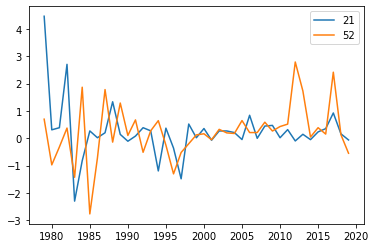

In [73]:
# plot sector regulation and variable correlation
fig, (ax2) = plt.subplots(1,1)
for sector in [21, 52]: 
    df_sector = df[df.sector_2 == sector]
    var = "emp"
    x = df_sector.year
    y1 = np.log(df_sector.industry_restrictions_2_0) - np.log(df_sector.industry_restrictions_2_0.shift(+1))
    y1_normalized = y1/y1.std()
    y1_long = (df_sector.industry_restrictions_2_0)
    y1_long_normalized = y1_long/y1_long.mean()

    ax2.plot(x, y1_normalized, label=f"{sector}")
ax2.legend()

In [ ]:
# plot sector regulation and variable correlation
for sector in df.sector_2.unique(): 
    df_sector = df[df.sector_2 == sector]
    var = "emp"
    x = df_sector.year
    y1 = np.log(df_sector.industry_restrictions_2_0) - np.log(df_sector.industry_restrictions_2_0.shift(+1))
    y1_normalized = y1/y1.std()
    y1_long = (df_sector.industry_restrictions_2_0)
    y1_long_normalized = y1_long/y1_long.mean()

    y2 = (df_sector[var] - df_sector[var].shift(1))
    y2_normalized = y2/y2.std()
    y2_long = (df_sector[var])
    y2_long_normalized = y2_long/y2_long.mean()

    fig, (ax1, ax2) = plt.subplots(2,1)
    ax1.plot(x, y1_normalized, label='Regulation')
    ax1.plot(x, y2_normalized, label=var)
    ax1.legend()

    ax2.plot(x, y1_long_normalized, label='Regulation')
    ax2.plot(x, y2_long_normalized, label=var)
    ax2.legend()

In [3]:
from linearmodels.iv import IV2SLS

# load life path data
datapath_sec = Path("data/cleaned/data_final_sec.h5")
df = pd.read_hdf(datapath_sec, key="data")

datapath_sec_ag = Path("data/cleaned/sector_age_panel.h5")
df_ag = pd.read_hdf(datapath_sec_ag, key="data")

df_ag_raw = pd.read_csv("C:/Users/zach_/Nobackupfile/Data/BDS/bds2019_naics_4_age.csv")

datapath_sec_sz = Path("data/cleaned/sector_age_size_panel.h5")
df_sz = pd.read_hdf(datapath_sec_sz, key="data")

depend_vars = [
  "log_emp", "log_avg_emp", "job_creation_rate",
  "job_destruction_rate", "net_job_creation_rate",
  "reallocation_rate", "death_rate",
  "L_0_entry_rate"
  ]

In [ ]:
df_ag_raw["firms"] = pd.to_numeric(df_ag_raw["firms"], errors="coerce", downcast=None)

In [ ]:
df_ag[df_ag.firms == 0]
df_ag_raw[(df_ag_raw.sector == 1100) &(df_ag_raw.year == 1978) ]

In [ ]:
# check lags
print(df.columns.tolist()[0:10])
df_test = df[(df.sector == 1100 ) & (df.year == 1985) ]

df_test1 = df_ag[(df_ag.sector == 1100 ) & (df_ag.year == 1985) ]

print(df_test.job_creation_rate)
print(df_test1.job_creation_rate.median())

### sector level

In [ ]:
dict1 = {}
dict1["index"] = ["OLS Coef", "", "P Value", "# obs"]
for depend_var in depend_vars:
    # load data
    data = df

    # sample restriction
    data = data[(data.year > 1985)&(data.year < 2020)]

    # regression
    data = data.set_index(['sector', 'year'])
    
    var_lst = [
      "L_0_log_restriction_2_0",
      "L_0_log_gdp", "L_1_log_gdp",
      depend_var, "sector_2", "firms"
      ]
    
    formula_txt = f'{depend_var} ~ L_0_log_gdp + L_1_log_gdp + L_0_log_restriction_2_0 + EntityEffects + TimeEffects'
    
    # regression
    data1 = data.loc[:, var_lst].dropna()
    mod1 = PanelOLS.from_formula(formula = formula_txt, weights=data1['firms'], data = data1, drop_absorbed=True)

    res = mod1.fit(cov_type='heteroskedastic')

    # results
    vnames = ["L_0_log_restriction_2_0"]
    for v_name in vnames:
        
        coefs_value = res.params[v_name][0]
        coefs_value = str(round(coefs_value, 5))
        std = res.std_errors[v_name]
        std = "[" + str(round(std, 5)) + "]"
        p_value = res.pvalues[v_name]
        stars = int(p_value < 0.01)*"*" + int(p_value < 0.05)*"*" + int(p_value < 0.1)*"*"
        coefs_value = coefs_value + stars
        p_value = str(round(p_value, 5))
        nobs = res.nobs
        dict1[f"{depend_var}"] =  [coefs_value, std, p_value, nobs]
    
df_coefs_age = pd.DataFrame(dict1)
df_coefs_age

In [ ]:
# iv estimation
temp_dict = []

for depend_var in depend_vars:
    # load data
    data = df

    # sample restriction
    data = data[(data.year > 1985)&(data.year < 2020)]

    var_list = [
      "L_0_log_restriction_2_0", "L_0_bartik_iv",
      "L_0_log_gdp", "L_1_log_gdp",
      depend_var, "sector_2", 'firms', "sector", "year"]
    
    formula_txt = f'{depend_var} ~ C(sector) + C(year) + L_0_log_gdp + L_1_log_gdp + [L_0_log_restriction_2_0 ~ L_0_bartik_iv]'
    
    # regression
    data1 = data.loc[:, var_list].dropna()
    mod1 = IV2SLS.from_formula(formula = formula_txt, weights=data1['firms'], data = data1)

    res = mod1.fit(cov_type='heteroskedastic')

    # results
    vnames = ["L_0_log_restriction_2_0"]
    for v_name in vnames:
        dict1 = {}
        coefs_value = res.params[v_name]
        std = res.std_errors[v_name]
        lower_ci = res.conf_int().loc[v_name, "lower"]
        upper_ci = res.conf_int().loc[v_name, "upper"]
        p_value = res.pvalues[v_name]
        nobs = res.nobs
        sign = (lower_ci * upper_ci > 0)
        dict1.update({"depend_var": depend_var, "Coef": coefs_value,
                      "std":std, "lower_ci": lower_ci, "upper_ci": upper_ci,
                      "p values":p_value, "significance": sign, "# obs":nobs}) 
        temp_dict.append(dict1)
    
df_coefs_age = pd.DataFrame(temp_dict)
df_coefs_age = df_coefs_age.sort_values(by=['depend_var'])
df_coefs_age

In [ ]:
# first stage estimation
temp_dict = []

# load data
data = df

# sample restriction
data = data[(data.year > 1985)&(data.year < 2020)]

# regression
data = data.set_index(['sector', 'year'])

var_lst = [
  "L_0_log_restriction_2_0", "L_0_bartik_iv",
  "L_0_log_gdp", "L_1_log_gdp",
  "death_rate", "emp",
  'sector_2', depend_var, 'firms'
  ]

formula_txt = f'L_0_log_restriction_2_0 ~ + L_0_log_gdp + L_0_bartik_iv + EntityEffects + TimeEffects'
# regression
data1 = data.loc[:, var_lst].dropna()
mod1 = PanelOLS.from_formula(formula = formula_txt, weights=data1['firms'], data = data1, drop_absorbed=True)

res = mod1.fit(cov_type='heteroskedastic')

# results
vnames = ["L_0_bartik_iv"]
for v_name in vnames:
    dict1 = {}
    coefs_value = res.params[v_name]
    std = res.std_errors[v_name]
    lower_ci = res.conf_int().loc[v_name, "lower"]
    upper_ci = res.conf_int().loc[v_name, "upper"]
    p_value = res.pvalues[v_name]
    nobs = res.nobs
    sign = (lower_ci * upper_ci > 0)
    dict1.update({"depend_var": depend_var, "Coef": coefs_value,
                  "std":std, "lower_ci": lower_ci, "upper_ci": upper_ci,
                  "p values":p_value, "significance": sign, "# obs":nobs}) 
    temp_dict.append(dict1)

df_coefs_age = pd.DataFrame(temp_dict)
df_coefs_age = df_coefs_age.sort_values(by=['depend_var'])
df_coefs_age

### heterogeneity on sizes

In [ ]:
df_sz.head()

In [ ]:
# ols estimation
temp_dict = []
depend_var = "estabs_exit_rate"
for age in df_sz.age_coarse.unique()[1:]:
    # load data
    data = df_sz[df_sz.age_coarse == age]

    # sample restriction
    data = data[(data.year > 1985)&(data.year < 2020)]
        
    var_list = [
      "L_0_log_restriction_2_0", "L_0_bartik_iv",
      "L_0_log_gdp", "L_1_log_gdp", "large_firm",
      depend_var, "sector_2", 'firms', "sector", "year"]
    
    formula_txt = f'{depend_var} ~ C(sector) + C(year) + L_0_log_gdp + L_1_log_gdp + large_firm \
      [L_0_log_restriction_2_0 + L_0_log_restriction_2_0:large_firm \
      ~ L_0_bartik_iv + L_0_bartik_iv:large_firm]'
    
    # regression
    data1 = data.loc[:, ].dropna()
    mod1 = IV2SLS.from_formula(formula = formula_txt, weights=data1["firms"], data = data1)

    res = mod1.fit(cov_type='heteroskedastic')

    # results
    vnames = ["L_0_log_restriction_2_0", "L_0_log_restriction_2_0:large_firm"]
    for v_name in vnames:
        dict1 = {}
        coefs_value = res.params[v_name]
        std = res.std_errors[v_name]
        lower_ci = res.conf_int().loc[v_name, "lower"]
        upper_ci = res.conf_int().loc[v_name, "upper"]
        p_value = res.pvalues[v_name]
        nobs = res.nobs
        sign = (lower_ci * upper_ci > 0)
        dict1.update({"depend_var": depend_var, "Coef": coefs_value, "age": age,
                      "std":std, "v_name":v_name, "lower_ci": lower_ci, "upper_ci": upper_ci,
                      "p values":p_value, "significance": sign, "# obs":nobs}) 
        temp_dict.append(dict1)
    
df_coefs_age = pd.DataFrame(temp_dict)
df_coefs_age = df_coefs_age.sort_values(by=['age', 'v_name'])
df_coefs_age

In [ ]:
# iv estimation
temp_dict = []

for depend_var in depend_vars:
    # load data
    data = df_sz

    # sample restriction
    data = data[(data.year > 1985)&(data.year < 2020)]

    var_list = [
      "L_0_log_restriction_2_0", "L_0_bartik_iv",
      "L_0_log_gdp", "L_1_log_gdp", "large_firm",
      depend_var, "sector_2", 'firms', "sector", "year"]
    
    formula_txt = f'{depend_var} ~ C(sector) + C(year) + L_0_log_gdp + L_1_log_gdp + large_firm \
      [L_0_log_restriction_2_0 + L_0_log_restriction_2_0:large_firm \
      ~ L_0_bartik_iv + L_0_bartik_iv:large_firm]'
    
    # regression
    data1 = data.loc[:, ].dropna()
    mod1 = IV2SLS.from_formula(formula = formula_txt, weights=data1['firms'], data = data1)

    res = mod1.fit(cov_type='heteroskedastic')

    # results
    vnames = ["L_0_log_restriction_2_0", "L_0_log_restriction_2_0:large_firm"]
    for v_name in vnames:
        dict1 = {}
        coefs_value = res.params[v_name]
        std = res.std_errors[v_name]
        lower_ci = res.conf_int().loc[v_name, "lower"]
        upper_ci = res.conf_int().loc[v_name, "upper"]
        p_value = res.pvalues[v_name]
        nobs = res.nobs
        sign = (lower_ci * upper_ci > 0)
        dict1.update({"depend_var": depend_var, "Coef": coefs_value, "v_name":v_name,
                      "std":std, "lower_ci": lower_ci, "upper_ci": upper_ci,
                      "p values":p_value, "significance": sign, "# obs":nobs}) 
        temp_dict.append(dict1)
    
df_coefs_age = pd.DataFrame(temp_dict)
df_coefs_age = df_coefs_age.sort_values(by=['depend_var'])
df_coefs_age

### heterogeneity on ages

In [4]:
# iv estimation
depend_vars = [
  "log_emp", "log_avg_emp", "job_creation_rate",
  "job_destruction_rate", "net_job_creation_rate",
  "reallocation_rate", "death_rate",
  ]

In [5]:
def plot_lp(v_name, df, depend_var, plot_name, fig_path, var_name, std):
    """
    plot_lp plot local projection graph
    Args:
        df [DataFrame]: Data contains coefs
        depend_var [str]: dependent variable
        plot_name [str]: name for the plot 
        var_names [lst]: lst of string of variable names
        fig_path [Path]: path of the figure
    Return:
        None
    """

    fig, ax = plt.subplots()
    depend_name = depend_var.replace("_", " ").title()

    df_sub = df[df.name == v_name]
    Age = df_sub.age.to_numpy().T
    Age = Age.astype(int)
    Coef = df_sub.Coef.to_numpy().T 
    Coef = Coef * std
    lower_ci = - df_sub[["lower_ci"]].to_numpy().T + df_sub.Coef.to_numpy().T 
    lower_ci  = lower_ci * std
    upper_ci = df_sub[["upper_ci"]].to_numpy().T - df_sub.Coef.to_numpy().T 
    upper_ci = upper_ci * std
    yerr = np.vstack((lower_ci, upper_ci))
    
    
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.scatter(Age, Coef)
    ax.errorbar(Age, Coef, yerr = yerr, fmt = 'o',color = 'orange', 
        ecolor = 'lightgreen', elinewidth = 3, capsize=5)   
    ax.axhline(y=0, color='r', linestyle=':')
    
    ax.set_title(f"{var_name}".title())
    ax.set_xlabel("Age")
    ax.set_ylabel(f"{depend_name}".title())
    
    fig.title(f'Effects of Regulation on {depend_name}')        
    fig.tight_layout()
    fig_final_path = fig_path/f"{plot_name}.png"
    fig.savefig(fig_final_path, facecolor='white', transparent=False)
    plt.close(fig)
    return None

In [ ]:
# ols estimation
for depend_var in depend_vars:
        
        # load data
        data = df_ag[df_ag.age_coarse != "00"]

        # sample restriction
        data = data[(data.year > 1985)&(data.year < 2020)]

        # regression
        data = data.set_index(['sector', 'year'])

        var_lst = [
          "L_0_log_restriction_2_0",
          "L_0_entry_rate","L_0_log_gdp",
          'sector_2', depend_var, 'firms']
        
        formula_txt = f'{depend_var} ~ L_0_entry_rate    \
                                     + L_0_log_gdp    \
                                     + L_0_log_restriction_2_0 + EntityEffects + TimeEffects'
                                     
        # regression
        data1 = data.loc[:, var_lst].dropna()
        mod1 = PanelOLS.from_formula(formula = formula_txt, weights=data1['firms'], data = data1, drop_absorbed=True)

        res = mod1.fit(cov_type='heteroskedastic')

        # results
        vnames = ["L_0_log_restriction_2_0"]
        for v_name in vnames:
            dict1 = {}
            coefs_value = res.params[v_name]
            std = res.std_errors[v_name]
            lower_ci = res.conf_int().loc[v_name, "lower"]
            upper_ci = res.conf_int().loc[v_name, "upper"]
            p_value = res.pvalues[v_name]
            nobs = res.nobs
            sign = (lower_ci * upper_ci > 0)
            dict1.update({"depend_var": depend_var, "age": age, "Coef": coefs_value,
                          "std":std, "lower_ci": lower_ci, "upper_ci": upper_ci,
                          "p values":p_value, "significance": sign, "# obs":nobs}) 
            temp_dict.append(dict1)
            
df_coefs_age = pd.DataFrame(temp_dict)
df_coefs_age = df_coefs_age.sort_values(by=['depend_var', 'age'])
df_coefs_age





In [ ]:
df = df_coefs_age
v_name = "log_emp"
fig, ax = plt.subplots()
depend_name = depend_var.replace("_", " ").title()

df_sub = df[df.depend_var == v_name]
Age = df_sub.age.to_numpy().T
Coef = df_sub.Coef.to_numpy().T 
Coef = Coef * std
lower_ci = - df_sub[["lower_ci"]].to_numpy().T + df_sub.Coef.to_numpy().T 
lower_ci  = lower_ci * std
upper_ci = df_sub[["upper_ci"]].to_numpy().T - df_sub.Coef.to_numpy().T 
upper_ci = upper_ci * std
yerr = np.vstack((lower_ci, upper_ci))

ax.scatter(Age, Coef)
ax.errorbar(Age, Coef, yerr = yerr, fmt = 'o',color = 'orange', 
    ecolor = 'lightgreen', elinewidth = 3, capsize=5)   
ax.axhline(y=0, color='r', linestyle=':')

ax.set_title(f"{var_name}".title())
ax.set_xlabel("Age")
ax.set_ylabel(f"{depend_name}".title())

fig.title(f'Effects of Regulation on {depend_name}')        
fig.tight_layout()

In [ ]:
vnames = ["L_0_log_restriction_2_0"]
plot_lp(v_names, df_coefs_age, depend_var, model_name, fig_path, var_names, std)

In [9]:
# IV 
import copy
from linearmodels.iv import IV2SLS

temp_dict = []
depend_var = "log_emp"
# load data
data = df_ag[df_ag.age_coarse != "00"]

# sample restriction
data = data[(data.year > 1985) & (data.year < 2020)]

var_lst = [
  "L_0_log_restriction_2_0", "L_0_bartik_iv", 
  "L_0_entry_rate",
  "L_0_log_gdp",
  "sector", "year",
    depend_var, "sector_2", 'firms', "age_coarse"
    ]

formula_txt = f'{depend_var} ~ C(year) + C(sector) + C(age_coarse) \
                              + L_0_entry_rate  \
                              + L_0_log_gdp     \
                              + [C(age_coarse):L_0_log_restriction_2_0 ~ C(age_coarse):L_0_bartik_iv]'
    
# regression
data1 = data.loc[:, var_lst].dropna()
mod1 = IV2SLS.from_formula(
  formula = formula_txt, weights=data1['firms'], data = data1
)

res = mod1.fit(cov_type='heteroskedastic')

res.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                log_emp   R-squared:                      0.9538
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9535
No. Observations:               65491   F-statistic:                 4.227e+07
Date:                Sat, Aug 20 2022   P-value (F-stat)                0.0000
Time:                        20:07:54   Distribution:                chi2(328)
Cov. Estimator:       heteroskedastic                                         
                                                                              
                                               Parameter Estimates                                                
==================================================================================================================
                                                Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------------------------------------
C(age_coarse)[T.01]                                7.1491     3.7588     1.9020     0.0572     -0.2181      14.516
C(age_coarse)[T.02]                                6.8492     3.7500     1.8265     0.0678     -0.5007      14.199
C(age_coarse)[T.03]                                6.6571     3.7460     1.7771     0.0755     -0.6849      13.999
C(age_coarse)[T.04]                                6.4328     3.7416     1.7193     0.0856     -0.9006      13.766
C(age_coarse)[T.05]                                6.1956     3.7387     1.6571     0.0975     -1.1321      13.523
C(age_coarse)[T.06-10]                             7.4627     3.7418     1.9944     0.0461      0.1290      14.796
C(age_coarse)[T.11+]                               8.2920     3.7316     2.2221     0.0263      0.9782      15.606
C(sector)[T.2121]                                 -0.0742     0.0631    -1.1760     0.2396     -0.1979      0.0495
C(sector)[T.2122]                                 -1.4592     0.0942    -15.493     0.0000     -1.6438     -1.2746
C(sector)[T.2123]                                 -0.1192     0.0693    -1.7187     0.0857     -0.2551      0.0167
C(sector)[T.2131]                                  0.7885     0.0466     16.931     0.0000      0.6972      0.8798
C(sector)[T.2211]                                  1.1968     0.1507     7.9392     0.0000      0.9014      1.4923
C(sector)[T.2212]                                 -0.8514     0.1528    -5.5713     0.0000     -1.1510     -0.5519
C(sector)[T.2213]                                 -1.1568     0.1139    -10.157     0.0000     -1.3801     -0.9336
C(sector)[T.2361]                                  0.9197     0.6101     1.5074     0.1317     -0.2761      2.1155
C(sector)[T.2362]                                  0.8437     0.5871     1.4371     0.1507     -0.3070      1.9943
C(sector)[T.2371]                                  0.3985     0.5877     0.6781     0.4977     -0.7534      1.5505
C(sector)[T.2372]                                 -1.4546     0.6077    -2.3937     0.0167     -2.6457     -0.2636
C(sector)[T.2373]                                 -0.0244     0.5769    -0.0423     0.9663     -1.1551      1.1063
C(sector)[T.2379]                                 -1.3539     0.5829    -2.3228     0.0202     -2.4964     -0.2115
C(sector)[T.2381]                                  1.0954     0.5939     1.8443     0.0651     -0.0687      2.2595
C(sector)[T.2382]                                  1.7406     0.5956     2.9224     0.0035      0.5732      2.9079
C(sector)[T.2383]                                  0.9757     0.6034     1.6171     0.1059     -0.2069      2.1582
C(sector)[T.2389]                                  0.4794     0.6018     0.7966     0.4257     -0.7002      1.6590
C(sector)[T.311

In [ ]:
df = df_coefs_age
depend_var = "log_emp"
fig, ax = plt.subplots()
depend_name = depend_var.replace("_", " ").title()

df_sub = df[df.depend_var == depend_var]
Age = df_sub.age.to_numpy().T
Coef = df_sub.Coef.to_numpy().T 
Coef = Coef * std
lower_ci = - df_sub[["lower_ci"]].to_numpy().T + df_sub.Coef.to_numpy().T 
lower_ci  = lower_ci * std
upper_ci = df_sub[["upper_ci"]].to_numpy().T - df_sub.Coef.to_numpy().T 
upper_ci = upper_ci * std
yerr = np.vstack((lower_ci, upper_ci))

ax.scatter(Age, Coef)
ax.errorbar(Age, Coef, yerr = yerr, fmt = 'o',color = 'orange', 
    ecolor = 'lightgreen', elinewidth = 3, capsize=5)   
ax.axhline(y=0, color='r', linestyle=':')

ax.set_title(f"{depend_name}".title())
ax.set_xlabel("Age")
ax.set_ylabel(f"{depend_name}".title())

fig.suptitle(f'Effects of Regulation on {depend_name}')        
fig.tight_layout()
#fig_final_path = fig_path/f"{plot_name}_{depend_name}.png"

#fig.savefig(fig_final_path, facecolor='white', transparent=False)
#plt.close(fig)

In [ ]:
# FIRST STAGE
from linearmodels.iv import IV2SLS

temp_dict = []
for age in df_ag.age_coarse.unique()[1:]:
    
    # load data
    data = df_ag[df_ag.age_coarse == age]

    # sample restriction
    data = data[(data.year > 1985) & (data.year < 2020)]

    var_lst = [
        "L_0_log_restriction_2_0", "L_0_bartik_iv", 
        "L_0_entry_rate",
        "L_0_log_gdp",
        "sector", "year",
          depend_var, "sector_2", 'firms'
          ]
        
    formula_txt = f'L_0_log_restriction_2_0 ~ C(year) + C(sector) \
                                  + L_0_entry_rate  \
                                  + L_0_log_gdp     \
                                  + [L_0_bartik_iv ~ L_0_bartik_iv]'
    # regression
    data1 = data.loc[:, var_lst].dropna()
        
    mod1 = IV2SLS.from_formula(
      formula = formula_txt, weights=data1['firms'], data = data1
    )

    res = mod1.fit(cov_type='heteroskedastic')

    # results
    vnames = ["L_0_bartik_iv"]
    for v_name in vnames:
        dict1 = {}
        coefs_value = res.params[v_name]
        std = res.std_errors[v_name]
        lower_ci = res.conf_int().loc[v_name, "lower"]
        upper_ci = res.conf_int().loc[v_name, "upper"]
        p_value = res.pvalues[v_name]
        nobs = res.nobs
        sign = (lower_ci * upper_ci > 0)
        dict1.update({"name": v_name, "age": age, "Coef": coefs_value,
                      "std":std, "lower_ci": lower_ci, "upper_ci": upper_ci,
                      "p values":p_value, "significance": sign, "# obs":nobs}) 
        temp_dict.append(dict1)
        
df_coefs_age = pd.DataFrame(temp_dict)
df_coefs_age = df_coefs_age.sort_values(by=['name', 'age'])
df_coefs_age

In [ ]:
# pooled data
# load data
depend_var = "log_avg_emp"
data = df[df.age_coarse != "00"]

# sample restriction
data = data[(data.year > 1985) & (data.year < 2020)]

# regression
data1 = data.loc[:, ["L_0_log_restriction_2_0", "L_1_log_restriction_2_0", "L_0_log_restriction_2_0_init",
                        "L_0_entry_rate_whole", "L_1_entry_rate_whole", "L_2_entry_rate_whole", "L_3_entry_rate_whole",
                        "L_0_log_gdp", "L_1_log_gdp", "L_2_log_gdp", "L_3_log_gdp",
                        "death_rate", "age_coarse", "emp", "year", "sector",
                        'sector_2', depend_var, 'firms']].dropna()
mod1 = IV2SLS.from_formula(formula = f'{depend_var} ~ C(age_coarse) + C(year) + C(sector) \
                                        + L_0_entry_rate_whole  \
                                        + L_0_log_gdp  \
                                        + [L_0_log_restriction_2_0:C(age_coarse) ~ L_0_log_restriction_2_0_init:C(age_coarse) ]',
                                        weights=data1['firms'], data = data1)

res = mod1.fit(cov_type='heteroskedastic')
res.summary;

In [ ]:
# create shift share

In [ ]:
def lag_variable(df, time_var, id_var, var, lags):
    """
    lag_variable create lag variables by groups   
    Args:
        df [DataFrame]: dataframe
        time_var [lst]: time variable
        id_var [list of string]: id variable
        var [lst]: lagged varible
        lags: number of lags (1 means one lag)
    """

    index_var = time_var + id_var

    df = df.set_index(index_var)
    df_shift = df[var]
    
    shifted = df_shift.groupby(level=id_var).shift(lags)
    shifted = shifted.rename(columns={var[0]: f"L_{lags}_{var[0]}"})
    df = df.join(shifted)
    df = df.reset_index()
    
    return df

In [ ]:
# load regulation data
df_doc = pd.read_csv("C:\\Users\\zach_\\Nobackupfile\\Data\\BDS\\Regdata\\regdata_4_0_documents.csv")
df_ind = pd.read_csv("C:\\Users\\zach_\\Nobackupfile\\Data\\BDS\\Regdata\\regdata_4_0_documents_2digit_naics.csv")

# clean variables
baseline_year = 1986
df_doc["year"] = pd.to_numeric(df_doc.year.str.slice(0,4))
df_ind["year"] = pd.to_numeric(df_ind.year.str.slice(0,4))

# create lag variable
df_doc = lag_variable(df_doc, ["year"], ["document_reference"], ["restrictions_2_0"], 1)

# create current measure
doc_var = ["year", "document_reference", "restrictions_1_0","restrictions_2_0", "L_1_restrictions_2_0"]
df_merge = df_ind.merge(df_doc[doc_var], how='left', on=["year", "document_reference"], validate="many_to_one")

df_init = df_merge.loc[df_merge.year == baseline_year, ["NAICS", "probability", "document_reference", "restrictions_2_0"]]
df_init = df_init.rename(columns = {"probability": "probability_init"})

In [ ]:
df_init.tail()

In [ ]:
df_init["reg_s_d_init"] = df_init["probability_init"] * df_init["restrictions_2_0"]
df_init["reg_s_init"] = df_init.groupby(["NAICS"])["reg_s_d_init"].transform(lambda x: x.sum())
df_init["share_init"] = np.where(df_init["reg_s_d_init"]>0, df_init["reg_s_d_init"] / df_init["reg_s_init"], 0) 
init_var = ["NAICS", "document_reference", "reg_s_d_init", "reg_s_init", "share_init"]
df_merge = df_merge.merge(df_init[init_var], how='left', on=["NAICS", "document_reference"], validate="many_to_one")

In [ ]:
for var in ["reg_s_d_init", "reg_s_init", "share_init"]:
    df_merge[var] = np.where(df_merge[var].isna(), 0, df_merge[var])

df_merge[df_merge.year > 1988].head()

In [ ]:
df_merge["reg_s_d"] = df_merge["probability"] * df_merge["restrictions_2_0"]
df_merge["reg_s"] = df_merge.groupby(["NAICS", "year"])["reg_s_d"].transform(lambda x: x.sum())
df_merge["share"] = np.where(df_merge["reg_s_d"] > 0, df_merge["reg_s_d"] / df_merge["reg_s"], 0) 
df_merge["log_reg_s_d"] = np.where(df_merge["reg_s_d"] > 0, np.log(df_merge["reg_s_d"]), 0)
df_merge["log_reg_d"] = np.where(df_merge["restrictions_2_0"] > 0, np.log(df_merge["restrictions_2_0"]), np.nan) 

In [ ]:
df_merge["bartik_iv"] = df_merge["log_reg_d"] * df_merge["share_init"]
df_merge["industry_restrictions_2_0"] = df_merge["reg_s_d"]

In [ ]:
regdata = df_merge.groupby(by=["year", "NAICS"])[["industry_restrictions_2_0", "bartik_iv"]].sum()

In [ ]:
regdata["log_restrictions_2_0"] = np.log(regdata["industry_restrictions_2_0"])

In [ ]:
regdata = regdata.reset_index()

In [ ]:
regdata[regdata.year > 1985].corr()

In [ ]:

ind_init_var = ["document_reference", "NAICS", "probability_init"]
df_merge = df_merge.merge(df_ind_init[ind_init_var], how='left', on=["document_reference", "NAICS"], validate="many_to_one")

df_merge["industry_restrictions_2_0"] = df_merge["restrictions_2_0"]*df_merge["probability"]

df_merge["industry_restrictions_2_0_init"] = df_merge["restrictions_2_0"]*df_merge["probability_init"]
df_merge["industry_restrictions_1_0"] = df_merge["restrictions_1_0"]*df_merge["probability"]
df_merge["industry_restrictions_1_0_init"] = df_merge["restrictions_1_0"]*df_merge["probability_init"]
df_merge["industry_restrictions_2_0_chg"] = (df_merge["restrictions_2_0"] - df_merge["L_1_restrictions_2_0"]) * df_merge["probability"]
df_merge["industry_restrictions_2_0_log_chg"] = (np.log(df_merge["restrictions_2_0"]) - np.log(df_merge["L_1_restrictions_2_0"]))*df_merge["probability"]
df_merge["industry_restrictions_2_0_chg_init"] = (df_merge["industry_restrictions_2_0"] - df_merge["L_1_restrictions_2_0"])*df_merge["probability_init"]
df_merge["industry_restrictions_2_0_log_chg_init"] = (np.log(df_merge["restrictions_2_0"]) - np.log(df_merge["L_1_restrictions_2_0"]))*df_merge["probability_init"]

regdata = df_merge.groupby(by=["year", "NAICS"])[["industry_restrictions_2_0", "industry_restrictions_2_0_init",
                                                    "industry_restrictions_2_0_chg", "industry_restrictions_2_0_chg_init",
                                                    "industry_restrictions_2_0_log_chg", "industry_restrictions_2_0_log_chg_init",
                                                    "industry_restrictions_1_0", "industry_restrictions_1_0_init"]].sum()
regdata = regdata.reset_index()
regdata = regdata.rename(columns={"NAICS":"sector_reg"})

In [ ]:
regdata.tail()

In [ ]:
df_ind.sort_values(["year", "NAICS"])
df_merge = df_ind.merge(df_doc[["year", "document_reference", "restrictions_2_0"]], how='left', on=["year", "document_reference"], validate="many_to_one")
df_merge["year_init"] = df_merge["year"] - 15
df_merge = df_merge.merge(df_ind_init[["year_init", "document_reference", "NAICS", "probability_init"]], how='left', on=["year_init", "document_reference", "NAICS"], validate="many_to_one")

In [ ]:
df_merge["weight_index"] = df_merge["restrictions_2_0"]*df_merge["probability"]
df_merge["weight_index_init"] = df_merge["restrictions_2_0"]*df_merge["probability_init"]

In [ ]:
df_merge.tail()

In [ ]:
df = df_merge.groupby(by=["year", "NAICS"])[["weight_index", "weight_index_init"]].sum()
df = df.reset_index()

In [ ]:
df_merge[(df_merge._merge == "left_only") & (df_merge.industry_description == "Wholesale Trade")].head()

In [ ]:
df.head()